In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

Loading test images and templates

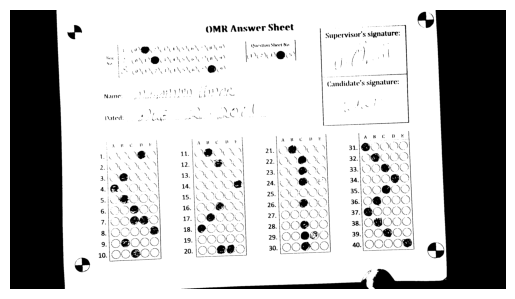

In [4]:
img_gray = cv2.imread('data.jpg', cv2.IMREAD_GRAYSCALE)
img_thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

plt.imshow(img_thresh, cmap='gray')
plt.title('')
plt.axis('off')
plt.show()

matches count 2


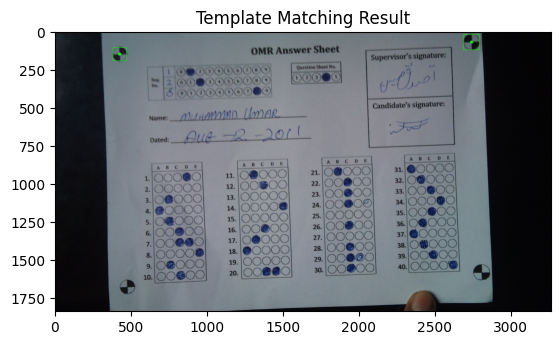

[(2735, 66), (424, 145)]
matches count 2


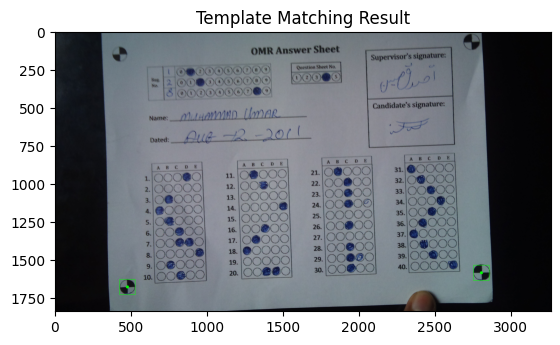

[(2800, 1584), (475, 1677)]


In [5]:
def template_matching(image_path, template_paths, half="upper", scale_range=(0.5, 1.5), step=0.1, threshold=0.8):
    """
    Performs template matching on a the input image to find the templates on the corners of the image.

    Parameters:
    - image_path (str): The path to the input image where template matching will be performed.
    - template_paths (list of str): A list of paths to the template images that need to be matched in the input image.
    - half (str, optional): Specifies which half of the image to consider for matching. It can be either "upper" or "lower". Default is "upper".
    - scale_range (tuple of float, optional): A tuple specifying the range of scaling factors to apply to the templates.
    - step (float, optional): The step size for scaling the templates within the specified scale range.
    - threshold (float, optional): The threshold  for considering a match valid.

    Returns:
    - center_locations (list of tuples): A list of tuples representing the center coordinates (x, y) of the matched template locations in the input image.

    Raises:
    - ValueError: If the value of 'half' is not "upper" or "lower".
    """
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if half == "upper":
        gray_image[height//2:, :] = 255
    elif half == "lower":
        gray_image[:height//2, :] = 255
    else:
        raise ValueError("Invalid value for 'half'. Use 'upper' or 'lower'.")

    match_locations = []
    center_locations = []

    for template_path in template_paths:
      template = cv2.imread(template_path, 0)
      template_height, template_width = template.shape

      best_match_value = -np.inf
      best_match_location = None
      best_scale = None

      for scale in np.arange(scale_range[0], scale_range[1], step):
          resized_template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
          result = cv2.matchTemplate(gray_image, resized_template, cv2.TM_CCOEFF_NORMED)

          min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

          if max_val >= threshold and max_val > best_match_value:
              best_match_value = max_val
              best_match_location = max_loc
              best_scale = scale

          if best_match_location is not None:
              match_locations.append((best_match_location, best_scale))
              break

    print('matches count', len(match_locations))
    for (pt, scale) in match_locations:
        best_height, best_width = int(template_height * scale), int(template_width * scale)
        top_left = pt
        bottom_right = (top_left[0] + best_width, top_left[1] + best_height)
        center_x = top_left[0] + best_width // 2
        center_y = top_left[1] + best_height // 2
        center_locations.append((center_x, center_y))
        cv2.circle(image, (center_x, center_y), 10, (0, 255, 0), -1)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Template Matching Result')
    plt.show()

    return center_locations


match_locations_upper = template_matching('data.jpg', ['rc.jpg', 'lc.jpg'], half="upper")
print(match_locations_upper)
match_locations_lower =  (template_matching('data.jpg', ['rc.jpg', 'lc.jpg'], half="lower"))
print(match_locations_lower)

In [6]:
unordered_points = match_locations_upper + match_locations_lower

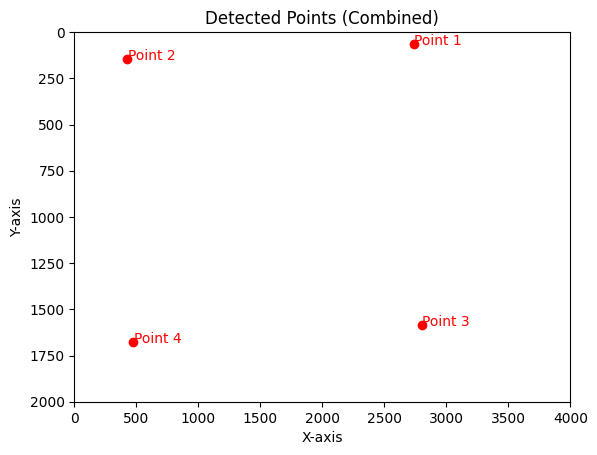

In [7]:
def plot_detected_points(points, title):
    fig, ax = plt.subplots()
    for i, point in enumerate(points):
        ax.plot(point[0], point[1], 'ro')
        ax.text(point[0] + 5, point[1] + 5, f'Point {i+1}', color='red')

    ax.set_xlim(0, 4000)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_detected_points(unordered_points, 'Detected Points (Combined)')

[[ 424.  145.]
 [2735.   66.]
 [2800. 1584.]
 [ 475. 1677.]]


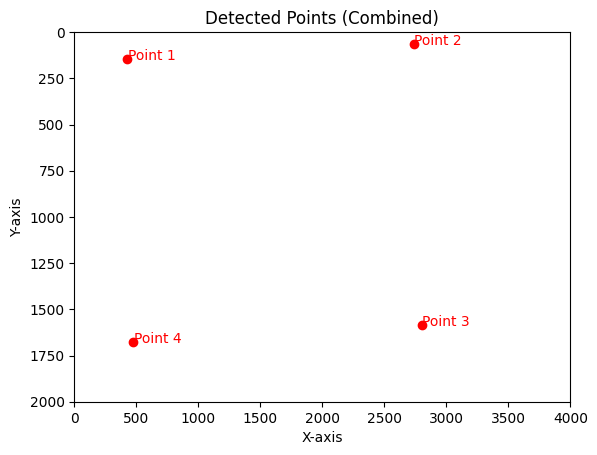

In [8]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

unordered_points = np.array(unordered_points)
ordered_points = order_points(unordered_points)
print(ordered_points)
plot_detected_points(ordered_points, 'Detected Points (Combined)')

In [9]:
def perspective_transform(image_path, points):
    """
    Performs a perspective transform,

    Parameters:
    - image_path (str): The path to the input image.
    - points (list of tuples): A list of four tuples representing the corner points in the original image.
                               The order should be top-left, top-right, bottom-right, and bottom-left.

    Returns:
    - result (numpy.ndarray): The transformed image.
    """
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    height, width = 2000, 3200

    # Points from the original image corners
    pts1 = np.float32(points)

    # Calculate the size of the new canvas based on the selected points
    new_width = width  # int(max(np.linalg.norm(pts1[0] - pts1[1]), np.linalg.norm(pts1[2] - pts1[3])))
    new_height = height  # int(max(np.linalg.norm(pts1[0] - pts1[3]), np.linalg.norm(pts1[1] - pts1[2])))

    # Destination points for the transform, adjusted to the calculated size
    pts2 = np.float32([
        [0, 0],  # Top-left
        [new_width - 1, 0],  # Top-right
        [new_width - 1, new_height - 1],  # Bottom-right
        [0, new_height - 1]  # Bottom-left
    ])

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img_gray, matrix, (new_width, new_height))

    # Display the transformed image
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Transformed Image')
    plt.axis('off')
    plt.show()

    return result

4


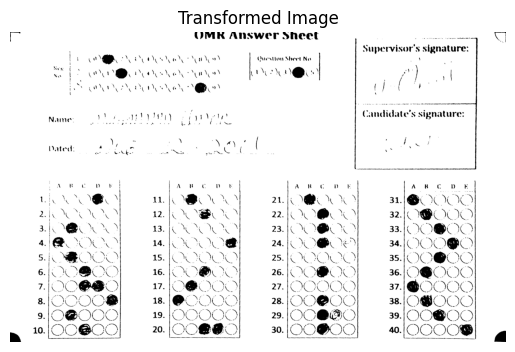

In [10]:
print(len(ordered_points))
# make sure we have at least 4 points.
if len(ordered_points) >= 4:
    # perspective transformation.
    fixed_image = perspective_transform('data.jpg', ordered_points)
else:
    print("not enough matching patterns were found.")

In [11]:
def is_majority_black(image, x, y, radius=5, threshold=170):
    """
    Checks if the majority of pixels in an area around the point (x, y) are black.

    Parameters:
    - image (numpy.ndarray): Grayscale image.
    - x (int): X-coordinate of the point.
    - y (int): Y-coordinate of the point.
    - radius (int, optional): Radius of the area around the point to check. Default is 5.
    - threshold (int, optional): Threshold to consider a pixel as white. Default is 170.

    Returns:
    - bool: True if the majority of the pixels in the area are black, otherwise False.
    """
    # Extract the area around the point
    area = image[y-radius:y+radius+1, x-radius:x+radius+1]

    # Count the number of white and black pixels
    num_white = np.sum(area >= threshold)
    num_black = np.sum(area < threshold)

    # Determine if the majority are black
    return num_black > num_white

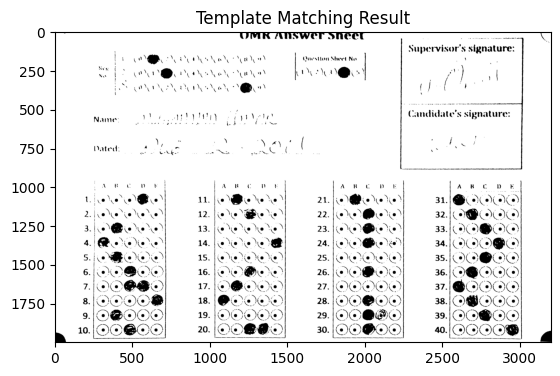

1 D
2 None
3 B
4 A
5 B
6 C
7 D
8 E
9 B
10 None
11 B
12 C
13 None
14 E
15 None
16 C
17 B
18 A
19 None
20 D
21 B
22 C
23 C
24 C
25 None
26 C
27 None
28 C
29 C
30 C
31 A
32 B
33 C
34 D
35 C
36 B
37 A
38 B
39 C
40 E


In [12]:
x_start = 310
y_start = 1085

x_step = 85
y_step = 93

block_step = 767


end = 2500
step = 62

notes = []

for block in range(0, 4):
  for r in range(0, 10):

    letter = "None"
    for c in range(0, 5):
      x =  x_start + (c * x_step) + (block * block_step)
      y = y_start + (r * y_step)

      intensity = fixed_image[y, x]

      if is_majority_black(fixed_image, x, y):
        if c == 0:
          letter = "A"
        elif c == 1:
          letter = "B"
        elif c == 2:
          letter = "C"
        elif c == 3:
          letter = "D"
        elif c == 4:
          letter = "E"

      cv2.circle(fixed_image, (x, y), 10, (0, 255, 0), -1)
    notes.append(letter)

plt.imshow(cv2.cvtColor(fixed_image, cv2.COLOR_BGR2RGB))
plt.title('Template Matching Result')
plt.show()

for i in range(0, len(notes)):
  print(i + 1, notes[i])